In [1]:
# --- 1. Import Libraries ---
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from pointRTD import PointRTDModel  # Import the PointRTD model
import os
import random
import numpy as np
from plyfile import PlyData
import trimesh  # For loading .off files as point clouds
import time
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm  # tqdm for Jupyter notebooks

In [2]:
# --- 2. Define Hyperparameters ---
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001# default was 0.001
WEIGHT_DECAY = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10
CORRUPTION_RATIO = 0.6
CHECKPOINT_DIR = f"./checkpoints_modelnet10/PointRTD/CR_{CORRUPTION_RATIO}"
PRETRAINED_CHECKPOINT = f"./checkpoints_pointrtd/pointrtd_epoch_62_CR_{CORRUPTION_RATIO}.pth"
LOG_DIR = "./tensorboard_logs_modelnet10"

# Create directories if they don't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
print("Device: ", DEVICE)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=LOG_DIR)

Device:  cuda


In [3]:
# --- 3. Define the ModelNet10 Dataset ---
class ModelNet10Dataset(Dataset):
    def __init__(self, root_dir, split='train', random_split=False, num_points=1024, seed=42, augment=False):
        """
        ModelNet10 dataset class.

        Args:
            root_dir (str): Root directory containing ModelNet10.
            split (str): 'train' or 'test'.
            random_split (bool): If True, use random data split instead of the preset split.
            num_points (int): Number of points to sample from each point cloud.
            seed (int): Random seed for reproducibility.
            augment (bool): Apply data augmentation if True.
        """
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points
        self.augment = augment
        self.data = []
        
        # Set up random split if specified
        if random_split:
            self.random_seed_split(seed)
        else:
            self.preset_split()
    
    def preset_split(self):
        """Use preset train/test split from ModelNet10."""
        classes = sorted(os.listdir(self.root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        for cls_name in classes:
            class_path = os.path.join(self.root_dir, cls_name, self.split)
            for file_name in os.listdir(class_path):
                if file_name.endswith('.off'):
                    self.data.append((os.path.join(class_path, file_name), self.class_to_idx[cls_name]))
    
    def random_seed_split(self, seed):
        """Create a random split by shuffling files."""
        random.seed(seed)
        classes = sorted(os.listdir(self.root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        for cls_name in classes:
            class_files = os.listdir(os.path.join(self.root_dir, cls_name))
            random.shuffle(class_files)
            split_idx = int(len(class_files) * 0.8)
            if self.split == 'train':
                self.data.extend([(os.path.join(self.root_dir, cls_name, f), self.class_to_idx[cls_name]) for f in class_files[:split_idx]])
            else:
                self.data.extend([(os.path.join(self.root_dir, cls_name, f), self.class_to_idx[cls_name]) for f in class_files[split_idx:]])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, class_idx = self.data[idx]
        mesh = trimesh.load(file_path)
        points = mesh.sample(self.num_points)
        points = np.array(points, dtype=np.float32)
        
        # Apply augmentation if specified
        if self.augment and self.split == 'train':
            points = self.apply_augmentations(points)
        
        return torch.tensor(points, dtype=torch.float32), class_idx

    def apply_augmentations(self, points):
        """Random scaling and translation."""
        scale = np.random.uniform(0.8, 1.2)
        points *= scale
        points += np.random.uniform(-0.1, 0.1, size=(1, 3))
        return points


# --- 4. Initialize Dataloaders ---
root_dir = './ModelNet10'
train_dataset = ModelNet10Dataset(root_dir, split='train', random_split=False, augment=True)
test_dataset = ModelNet10Dataset(root_dir, split='test', random_split=False, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
# --- 5. Load Pretrained Model and Set Up Classifier ---
# Load pretrained PointMAE model
token_dim = 256
hidden_dim = 256
num_heads = 8
num_layers = 6
num_patches = 64
num_pts_per_patch = 32
num_channels = 3
corruption_ratio = CORRUPTION_RATIO
noise_scale = 1

# Initialize PointRTD Model
pointrtd_model = PointRTDModel(
    input_dim=num_channels,
    token_dim=token_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    corruption_ratio=corruption_ratio,
    noise_scale=noise_scale,
    num_patches=num_patches,
    num_pts_per_patch=num_pts_per_patch,
    finetune=True, # Disable masking 
).to(DEVICE)

if os.path.isfile(PRETRAINED_CHECKPOINT):
    print(f"Loading checkpoint from {PRETRAINED_CHECKPOINT}")
    state_dict = torch.load(PRETRAINED_CHECKPOINT, map_location=DEVICE, weights_only=True)['model_state_dict']
    pointrtd_model.load_state_dict(state_dict)
    print("Checkpoint loaded successfully.")
else:
    print(f"Checkpoint not found at {PRETRAINED_CHECKPOINT}")

encoder = pointrtd_model.encoder

class EncoderWithClassifier(nn.Module):
    def __init__(self, encoder, token_dim=256, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(token_dim * 3, num_classes, bias=False)  # token_dim * 3 due to concatenation
        
    def forward(self, x):
        # Encode the input to get tokens
        encoded_tokens, *_ = self.encoder(x)  # Shape: (B, num_patches, token_dim)
        
        # Extract CLS token (first token)
        cls_token = encoded_tokens[:, 0, :]  # Shape: (B, token_dim)

        # Mean pooling across all tokens
        mean_pooled = encoded_tokens.mean(dim=1)  # Shape: (B, token_dim)

        # Max pooling across all tokens
        max_pooled, _ = encoded_tokens.max(dim=1)  # Shape: (B, token_dim)

        # Concatenate CLS token, mean-pooled, and max-pooled features
        combined_features = torch.cat([cls_token, mean_pooled, max_pooled], dim=-1)  # Shape: (B, token_dim * 3)

        # Pass through the classifier head
        logits = self.classifier(combined_features)  # Shape: (B, num_classes)
        return logits

classification_model = EncoderWithClassifier(encoder, token_dim=256, num_classes=NUM_CLASSES).to(DEVICE)

Loading checkpoint from ./checkpoints_pointrtd/pointrtd_epoch_62_CR_0.6.pth
Checkpoint loaded successfully.


In [5]:
# --- Calculate class distribution for cross entropy class weights
# --- MAY TAKE A WHILE
# from collections import Counter
# import torch

# # Step 1: Initialize a counter
# class_counts = Counter()

# # Step 2: Count the occurrences of each class in the training dataset
# for _, label in train_dataset:
#     class_counts[label] += 1

# # Step 3: Convert counts to a list
# num_classes = len(class_counts)
# class_count_list = [class_counts[i] for i in range(num_classes)]
class_count_list = [106, 515, 889, 200, 200, 465, 200, 680, 392, 344] # Precomputed 

# Step 4: Compute class weights (optional, for use in CrossEntropyLoss)
total_samples = sum(class_count_list)
class_weights = [total_samples / count for count in class_count_list]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

print("Class Counts:", class_count_list)
print("Class Weights:", class_weights)


Class Counts: [106, 515, 889, 200, 200, 465, 200, 680, 392, 344]
Class Weights: [37.65094339622642, 7.749514563106796, 4.4893138357705284, 19.955, 19.955, 8.58279569892473, 19.955, 5.8691176470588236, 10.181122448979592, 11.601744186046512]


In [6]:
# --- 6. Define Optimizer and Scheduler ---
optimizer = optim.AdamW(classification_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0)

In [8]:
# --- 7. Define Training Loop with tqdm ---
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    
    # Initialize CrossEntropy loss
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    for batch_idx, (points, labels) in progress_bar:
        points, labels = points.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update tqdm progress bar
        progress_bar.set_postfix(Batch=f"{batch_idx+1}/{len(loader)}", Loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def validate_one_epoch(model, loader, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Initialize CrossEntropy loss
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    with torch.no_grad():
        progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"Validation Epoch [{epoch+1}/{EPOCHS}]")
        for batch_idx, (points, labels) in progress_bar:
            points, labels = points.to(DEVICE), labels.to(DEVICE)
            outputs = model(points)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm progress bar
            progress_bar.set_postfix(Batch=f"{batch_idx+1}/{len(loader)}", Loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
# Initialize a variable to keep track of the lowest validation loss
best_val_loss = float('inf')
best_epoch = -1  # To track the epoch of the best model

# --- 8. Training and Validation Loop ---
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(classification_model, train_loader, optimizer, epoch)
    val_loss, val_acc = validate_one_epoch(classification_model, test_loader, epoch)
    
    # Step the scheduler
    scheduler.step()
    
    # Log metrics to TensorBoard
    writer.add_scalar("Train/Loss", train_loss, epoch)
    writer.add_scalar("Train/Accuracy", train_acc, epoch)
    writer.add_scalar("Validation/Loss", val_loss, epoch)
    writer.add_scalar("Validation/Accuracy", val_acc, epoch)
    writer.add_scalar("Learning_Rate", scheduler.get_last_lr()[0], epoch)

    # Print epoch stats
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"classification_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': classification_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, checkpoint_path)

        print(f"Checkpoint saved at {checkpoint_path}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1  # Update to the current epoch (1-based index)
        best_checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_epoch_{best_epoch}.pth")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': classification_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, best_checkpoint_path)

        print(f"New best model saved with Val Loss: {val_loss:.4f} at epoch {best_epoch}")

# Close TensorBoard writer
writer.close()
print("Training complete.")


Epoch [1/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [1/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1/300] - Train Loss: 2.3770, Train Acc: 0.1984, Val Loss: 2.1692, Val Acc: 0.2335
New best model saved with Val Loss: 2.1692 at epoch 1


Epoch [2/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [2/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2/300] - Train Loss: 1.8342, Train Acc: 0.3929, Val Loss: 1.8200, Val Acc: 0.3800
New best model saved with Val Loss: 1.8200 at epoch 2


Epoch [3/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [3/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3/300] - Train Loss: 1.5035, Train Acc: 0.5081, Val Loss: 1.6539, Val Acc: 0.4460
New best model saved with Val Loss: 1.6539 at epoch 3


Epoch [4/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [4/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4/300] - Train Loss: 1.2483, Train Acc: 0.6099, Val Loss: 1.1562, Val Acc: 0.6057
New best model saved with Val Loss: 1.1562 at epoch 4


Epoch [5/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [5/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5/300] - Train Loss: 1.0509, Train Acc: 0.6780, Val Loss: 1.3009, Val Acc: 0.5352


Epoch [6/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [6/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6/300] - Train Loss: 0.9010, Train Acc: 0.7324, Val Loss: 0.8929, Val Acc: 0.6894
New best model saved with Val Loss: 0.8929 at epoch 6


Epoch [7/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [7/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7/300] - Train Loss: 0.8023, Train Acc: 0.7702, Val Loss: 0.9072, Val Acc: 0.7214


Epoch [8/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [8/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8/300] - Train Loss: 0.7742, Train Acc: 0.7640, Val Loss: 0.6860, Val Acc: 0.7643
New best model saved with Val Loss: 0.6860 at epoch 8


Epoch [9/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [9/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9/300] - Train Loss: 0.7068, Train Acc: 0.7853, Val Loss: 0.7721, Val Acc: 0.7137


Epoch [10/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [10/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10/300] - Train Loss: 0.6655, Train Acc: 0.8141, Val Loss: 0.6361, Val Acc: 0.7808
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_10.pth
New best model saved with Val Loss: 0.6361 at epoch 10


Epoch [11/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [11/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [11/300] - Train Loss: 0.5730, Train Acc: 0.8314, Val Loss: 0.7775, Val Acc: 0.7324


Epoch [12/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [12/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [12/300] - Train Loss: 0.5684, Train Acc: 0.8279, Val Loss: 0.6483, Val Acc: 0.7786


Epoch [13/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [13/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [13/300] - Train Loss: 0.6012, Train Acc: 0.8153, Val Loss: 0.5396, Val Acc: 0.8029
New best model saved with Val Loss: 0.5396 at epoch 13


Epoch [14/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [14/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [14/300] - Train Loss: 0.5159, Train Acc: 0.8507, Val Loss: 0.5941, Val Acc: 0.7952


Epoch [15/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [15/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [15/300] - Train Loss: 0.5658, Train Acc: 0.8349, Val Loss: 0.6613, Val Acc: 0.7764


Epoch [16/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [16/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [16/300] - Train Loss: 0.5249, Train Acc: 0.8409, Val Loss: 0.4426, Val Acc: 0.8447
New best model saved with Val Loss: 0.4426 at epoch 16


Epoch [17/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [17/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [17/300] - Train Loss: 0.4995, Train Acc: 0.8582, Val Loss: 0.5868, Val Acc: 0.7985


Epoch [18/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [18/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [18/300] - Train Loss: 0.5164, Train Acc: 0.8452, Val Loss: 0.6656, Val Acc: 0.7919


Epoch [19/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [19/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [19/300] - Train Loss: 0.5343, Train Acc: 0.8509, Val Loss: 0.5888, Val Acc: 0.8051


Epoch [20/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [20/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [20/300] - Train Loss: 0.4460, Train Acc: 0.8712, Val Loss: 0.5507, Val Acc: 0.8216
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_20.pth


Epoch [21/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [21/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [21/300] - Train Loss: 0.5222, Train Acc: 0.8592, Val Loss: 0.5849, Val Acc: 0.8293


Epoch [22/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [22/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [22/300] - Train Loss: 0.4319, Train Acc: 0.8777, Val Loss: 0.4697, Val Acc: 0.8447


Epoch [23/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [23/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [23/300] - Train Loss: 0.5668, Train Acc: 0.8474, Val Loss: 0.5694, Val Acc: 0.8051


Epoch [24/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [24/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [24/300] - Train Loss: 0.4517, Train Acc: 0.8790, Val Loss: 0.3735, Val Acc: 0.8700
New best model saved with Val Loss: 0.3735 at epoch 24


Epoch [25/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [25/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [25/300] - Train Loss: 0.3419, Train Acc: 0.9038, Val Loss: 0.5190, Val Acc: 0.8183


Epoch [26/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [26/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [26/300] - Train Loss: 0.4165, Train Acc: 0.8885, Val Loss: 0.4149, Val Acc: 0.8667


Epoch [27/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [27/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [27/300] - Train Loss: 0.3491, Train Acc: 0.9005, Val Loss: 0.3650, Val Acc: 0.8789
New best model saved with Val Loss: 0.3650 at epoch 27


Epoch [28/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [28/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [28/300] - Train Loss: 0.3676, Train Acc: 0.8953, Val Loss: 0.5074, Val Acc: 0.8161


Epoch [29/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [29/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [29/300] - Train Loss: 0.4108, Train Acc: 0.8872, Val Loss: 0.4374, Val Acc: 0.8568


Epoch [30/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [30/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [30/300] - Train Loss: 0.3566, Train Acc: 0.8953, Val Loss: 0.6185, Val Acc: 0.7963
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_30.pth


Epoch [31/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [31/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [31/300] - Train Loss: 0.3588, Train Acc: 0.8983, Val Loss: 0.6312, Val Acc: 0.7974


Epoch [32/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [32/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [32/300] - Train Loss: 0.4301, Train Acc: 0.8822, Val Loss: 0.4322, Val Acc: 0.8601


Epoch [33/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [33/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [33/300] - Train Loss: 0.3727, Train Acc: 0.8920, Val Loss: 0.4503, Val Acc: 0.8568


Epoch [34/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [34/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [34/300] - Train Loss: 0.3873, Train Acc: 0.8935, Val Loss: 0.4115, Val Acc: 0.8689


Epoch [35/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [35/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [35/300] - Train Loss: 0.3315, Train Acc: 0.9065, Val Loss: 0.3655, Val Acc: 0.8789


Epoch [36/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [36/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [36/300] - Train Loss: 0.4280, Train Acc: 0.8890, Val Loss: 0.5825, Val Acc: 0.8106


Epoch [37/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [37/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [37/300] - Train Loss: 0.3827, Train Acc: 0.8890, Val Loss: 0.5274, Val Acc: 0.8315


Epoch [38/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [38/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [38/300] - Train Loss: 0.3302, Train Acc: 0.9090, Val Loss: 0.4017, Val Acc: 0.8733


Epoch [39/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [39/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [39/300] - Train Loss: 0.3001, Train Acc: 0.9158, Val Loss: 0.5131, Val Acc: 0.8304


Epoch [40/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [40/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [40/300] - Train Loss: 0.3729, Train Acc: 0.8963, Val Loss: 0.5132, Val Acc: 0.8480
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_40.pth


Epoch [41/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [41/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [41/300] - Train Loss: 0.2984, Train Acc: 0.9141, Val Loss: 0.3444, Val Acc: 0.8756
New best model saved with Val Loss: 0.3444 at epoch 41


Epoch [42/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [42/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [42/300] - Train Loss: 0.2711, Train Acc: 0.9256, Val Loss: 0.3990, Val Acc: 0.8601


Epoch [43/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [43/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [43/300] - Train Loss: 0.3094, Train Acc: 0.9110, Val Loss: 0.4558, Val Acc: 0.8568


Epoch [44/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [44/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [44/300] - Train Loss: 0.3504, Train Acc: 0.9100, Val Loss: 0.4648, Val Acc: 0.8524


Epoch [45/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [45/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [45/300] - Train Loss: 0.3881, Train Acc: 0.8923, Val Loss: 0.7226, Val Acc: 0.7808


Epoch [46/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [46/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [46/300] - Train Loss: 0.2912, Train Acc: 0.9146, Val Loss: 0.3646, Val Acc: 0.8877


Epoch [47/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [47/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [47/300] - Train Loss: 0.2629, Train Acc: 0.9261, Val Loss: 0.3759, Val Acc: 0.8833


Epoch [48/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [48/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [48/300] - Train Loss: 0.2932, Train Acc: 0.9176, Val Loss: 0.3402, Val Acc: 0.8767
New best model saved with Val Loss: 0.3402 at epoch 48


Epoch [49/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [49/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [49/300] - Train Loss: 0.2999, Train Acc: 0.9108, Val Loss: 0.3162, Val Acc: 0.8844
New best model saved with Val Loss: 0.3162 at epoch 49


Epoch [50/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [50/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [50/300] - Train Loss: 0.2912, Train Acc: 0.9156, Val Loss: 0.3147, Val Acc: 0.9020
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_50.pth
New best model saved with Val Loss: 0.3147 at epoch 50


Epoch [51/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [51/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [51/300] - Train Loss: 0.3043, Train Acc: 0.9151, Val Loss: 0.4213, Val Acc: 0.8656


Epoch [52/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [52/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [52/300] - Train Loss: 0.3190, Train Acc: 0.9148, Val Loss: 0.3479, Val Acc: 0.8866


Epoch [53/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [53/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [53/300] - Train Loss: 0.3271, Train Acc: 0.9063, Val Loss: 0.3982, Val Acc: 0.8767


Epoch [54/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [54/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [54/300] - Train Loss: 0.2494, Train Acc: 0.9323, Val Loss: 0.4293, Val Acc: 0.8634


Epoch [55/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [55/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [55/300] - Train Loss: 0.3479, Train Acc: 0.9008, Val Loss: 0.5667, Val Acc: 0.8249


Epoch [56/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [56/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [56/300] - Train Loss: 0.3689, Train Acc: 0.9018, Val Loss: 0.4523, Val Acc: 0.8678


Epoch [57/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [57/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [57/300] - Train Loss: 0.3444, Train Acc: 0.9045, Val Loss: 0.5132, Val Acc: 0.8700


Epoch [58/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [58/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [58/300] - Train Loss: 0.2859, Train Acc: 0.9223, Val Loss: 0.3605, Val Acc: 0.8877


Epoch [59/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [59/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [59/300] - Train Loss: 0.2331, Train Acc: 0.9346, Val Loss: 0.3491, Val Acc: 0.8877


Epoch [60/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [60/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [60/300] - Train Loss: 0.2618, Train Acc: 0.9278, Val Loss: 0.4176, Val Acc: 0.8678
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_60.pth


Epoch [61/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [61/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [61/300] - Train Loss: 0.2742, Train Acc: 0.9238, Val Loss: 0.3321, Val Acc: 0.8976


Epoch [62/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [62/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [62/300] - Train Loss: 0.2375, Train Acc: 0.9341, Val Loss: 0.3641, Val Acc: 0.8800


Epoch [63/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [63/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [63/300] - Train Loss: 0.2756, Train Acc: 0.9248, Val Loss: 0.3700, Val Acc: 0.8866


Epoch [64/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [64/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [64/300] - Train Loss: 0.3053, Train Acc: 0.9233, Val Loss: 0.3363, Val Acc: 0.8888


Epoch [65/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [65/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [65/300] - Train Loss: 0.2244, Train Acc: 0.9371, Val Loss: 0.3099, Val Acc: 0.9009
New best model saved with Val Loss: 0.3099 at epoch 65


Epoch [66/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [66/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [66/300] - Train Loss: 0.2556, Train Acc: 0.9318, Val Loss: 0.3906, Val Acc: 0.8689


Epoch [67/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [67/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [67/300] - Train Loss: 0.3191, Train Acc: 0.9121, Val Loss: 0.3338, Val Acc: 0.8888


Epoch [68/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [68/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [68/300] - Train Loss: 0.2242, Train Acc: 0.9361, Val Loss: 0.4149, Val Acc: 0.8744


Epoch [69/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [69/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [69/300] - Train Loss: 0.3005, Train Acc: 0.9223, Val Loss: 0.4054, Val Acc: 0.8767


Epoch [70/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [70/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [70/300] - Train Loss: 0.2146, Train Acc: 0.9454, Val Loss: 0.5213, Val Acc: 0.8612
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_70.pth


Epoch [71/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [71/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [71/300] - Train Loss: 0.2764, Train Acc: 0.9256, Val Loss: 0.3051, Val Acc: 0.8899
New best model saved with Val Loss: 0.3051 at epoch 71


Epoch [72/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [72/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [72/300] - Train Loss: 0.2074, Train Acc: 0.9429, Val Loss: 0.4802, Val Acc: 0.8667


Epoch [73/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [73/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [73/300] - Train Loss: 0.2630, Train Acc: 0.9326, Val Loss: 0.3674, Val Acc: 0.8855


Epoch [74/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [74/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [74/300] - Train Loss: 0.2139, Train Acc: 0.9401, Val Loss: 0.4632, Val Acc: 0.8557


Epoch [75/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [75/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [75/300] - Train Loss: 0.2416, Train Acc: 0.9341, Val Loss: 0.3585, Val Acc: 0.8778


Epoch [76/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [76/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [76/300] - Train Loss: 0.2171, Train Acc: 0.9401, Val Loss: 0.4142, Val Acc: 0.8667


Epoch [77/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [77/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [77/300] - Train Loss: 0.2667, Train Acc: 0.9318, Val Loss: 0.2845, Val Acc: 0.9152
New best model saved with Val Loss: 0.2845 at epoch 77


Epoch [78/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [78/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [78/300] - Train Loss: 0.3057, Train Acc: 0.9148, Val Loss: 0.3564, Val Acc: 0.8921


Epoch [79/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [79/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [79/300] - Train Loss: 0.2142, Train Acc: 0.9414, Val Loss: 0.3996, Val Acc: 0.8733


Epoch [80/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [80/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [80/300] - Train Loss: 0.2381, Train Acc: 0.9318, Val Loss: 0.4195, Val Acc: 0.8767
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_80.pth


Epoch [81/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [81/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [81/300] - Train Loss: 0.2045, Train Acc: 0.9441, Val Loss: 0.3763, Val Acc: 0.8833


Epoch [82/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [82/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [82/300] - Train Loss: 0.2137, Train Acc: 0.9436, Val Loss: 0.3788, Val Acc: 0.8855


Epoch [83/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [83/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [83/300] - Train Loss: 0.2047, Train Acc: 0.9421, Val Loss: 0.4293, Val Acc: 0.8590


Epoch [84/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [84/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [84/300] - Train Loss: 0.2094, Train Acc: 0.9404, Val Loss: 0.3535, Val Acc: 0.8833


Epoch [85/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [85/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [85/300] - Train Loss: 0.1725, Train Acc: 0.9526, Val Loss: 0.2598, Val Acc: 0.9141
New best model saved with Val Loss: 0.2598 at epoch 85


Epoch [86/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [86/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [86/300] - Train Loss: 0.1752, Train Acc: 0.9491, Val Loss: 0.3116, Val Acc: 0.8998


Epoch [87/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [87/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [87/300] - Train Loss: 0.2065, Train Acc: 0.9474, Val Loss: 0.4121, Val Acc: 0.8645


Epoch [88/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [88/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [88/300] - Train Loss: 0.2068, Train Acc: 0.9419, Val Loss: 0.4726, Val Acc: 0.8689


Epoch [89/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [89/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [89/300] - Train Loss: 0.2188, Train Acc: 0.9409, Val Loss: 0.3757, Val Acc: 0.8744


Epoch [90/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [90/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [90/300] - Train Loss: 0.1954, Train Acc: 0.9494, Val Loss: 0.4978, Val Acc: 0.8535
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_90.pth


Epoch [91/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [91/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [91/300] - Train Loss: 0.1863, Train Acc: 0.9486, Val Loss: 0.3925, Val Acc: 0.8678


Epoch [92/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [92/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [92/300] - Train Loss: 0.1605, Train Acc: 0.9562, Val Loss: 0.5168, Val Acc: 0.8822


Epoch [93/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [93/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [93/300] - Train Loss: 0.1973, Train Acc: 0.9461, Val Loss: 0.3088, Val Acc: 0.8921


Epoch [94/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [94/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [94/300] - Train Loss: 0.1881, Train Acc: 0.9499, Val Loss: 0.3321, Val Acc: 0.8976


Epoch [95/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [95/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [95/300] - Train Loss: 0.2521, Train Acc: 0.9341, Val Loss: 0.4112, Val Acc: 0.8833


Epoch [96/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [96/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [96/300] - Train Loss: 0.2184, Train Acc: 0.9389, Val Loss: 0.3159, Val Acc: 0.8987


Epoch [97/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [97/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [97/300] - Train Loss: 0.2028, Train Acc: 0.9396, Val Loss: 0.3558, Val Acc: 0.8998


Epoch [98/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [98/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [98/300] - Train Loss: 0.2011, Train Acc: 0.9424, Val Loss: 0.3007, Val Acc: 0.9130


Epoch [99/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [99/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [99/300] - Train Loss: 0.1524, Train Acc: 0.9584, Val Loss: 0.3634, Val Acc: 0.8877


Epoch [100/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [100/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [100/300] - Train Loss: 0.1714, Train Acc: 0.9526, Val Loss: 0.3086, Val Acc: 0.9097
Checkpoint saved at ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_100.pth


Epoch [101/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [101/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [101/300] - Train Loss: 0.1795, Train Acc: 0.9494, Val Loss: 0.3715, Val Acc: 0.8789


Epoch [102/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [102/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [102/300] - Train Loss: 0.4266, Train Acc: 0.8930, Val Loss: 0.4269, Val Acc: 0.8700


Epoch [103/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [103/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [103/300] - Train Loss: 0.2557, Train Acc: 0.9263, Val Loss: 0.4261, Val Acc: 0.8722


Epoch [104/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [104/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [104/300] - Train Loss: 0.2141, Train Acc: 0.9466, Val Loss: 0.3387, Val Acc: 0.9009


Epoch [105/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [105/300]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [105/300] - Train Loss: 0.1805, Train Acc: 0.9514, Val Loss: 0.3669, Val Acc: 0.8943


Epoch [106/300]:   0%|          | 0/125 [00:00<?, ?it/s]

Validation Epoch [106/300]:   0%|          | 0/29 [00:00<?, ?it/s]

In [8]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# --- Load Classification Model Checkpoint ---
def load_classification_checkpoint(model, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Checkpoint loaded successfully.")
    else:
        print(f"Checkpoint not found at {checkpoint_path}")


# --- Evaluate Model on Test Set with Voting ---
def evaluate_model_with_voting(model, loader, num_votes=10, class_names=None):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for points, labels in tqdm(loader, desc="Evaluating Test Set with Voting"):
            points, labels = points.to(DEVICE), labels.to(DEVICE)
            batch_size = points.size(0)
            vote_predictions = []

            for v in range(num_votes):
                # Apply random augmentations to the points
                augmented_points = apply_test_augmentations(points.clone())

                # Forward pass
                outputs = model(augmented_points)
                _, predicted = outputs.max(1)
                vote_predictions.append(predicted.cpu().numpy())

            # Majority voting
            vote_predictions = np.array(vote_predictions)  # Shape: (num_votes, batch_size)
            final_predictions = []

            for i in range(batch_size):
                votes = vote_predictions[:, i]
                most_common = Counter(votes).most_common(1)[0][0]
                final_predictions.append(most_common)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(final_predictions)

    # Calculate accuracy and F1 score
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_f1_score = f1_score(all_labels, all_predictions, average='weighted')

    # Calculate and optionally display confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    if class_names is not None:
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        print("Confusion Matrix:")
        print(conf_matrix)

    return test_accuracy, test_f1_score, conf_matrix

def apply_test_augmentations(points):
    """Apply random rotations and jittering for test-time augmentation."""
    return points


Evaluating Model at Epoch 300...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_300.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

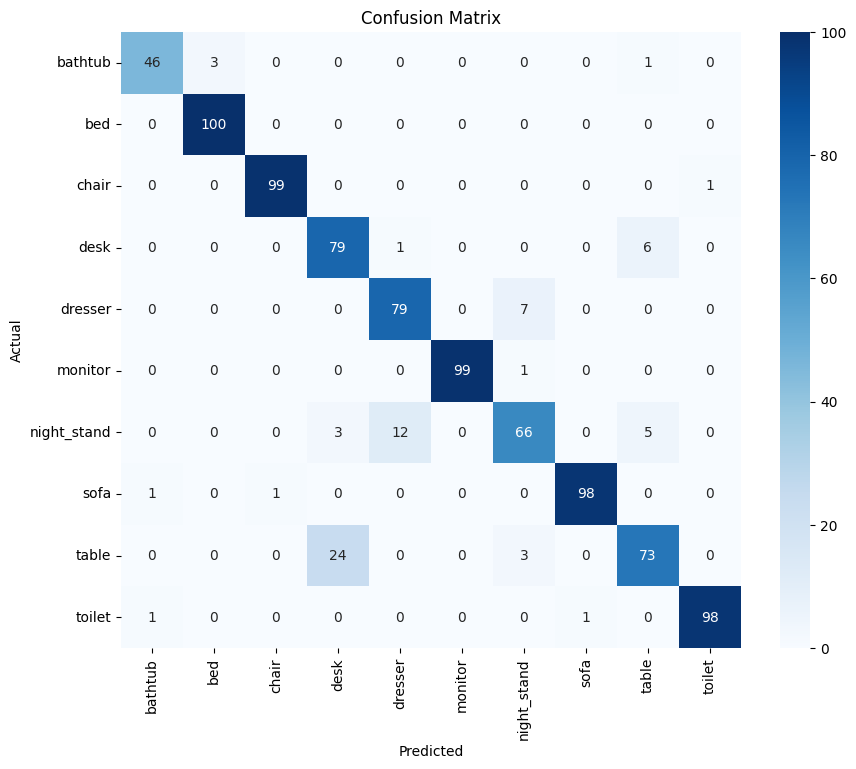

Accuracy: 0.9218061674008811; F1 Score: 0.9213814512569043;

Evaluating Model at Epoch 250...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_250.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

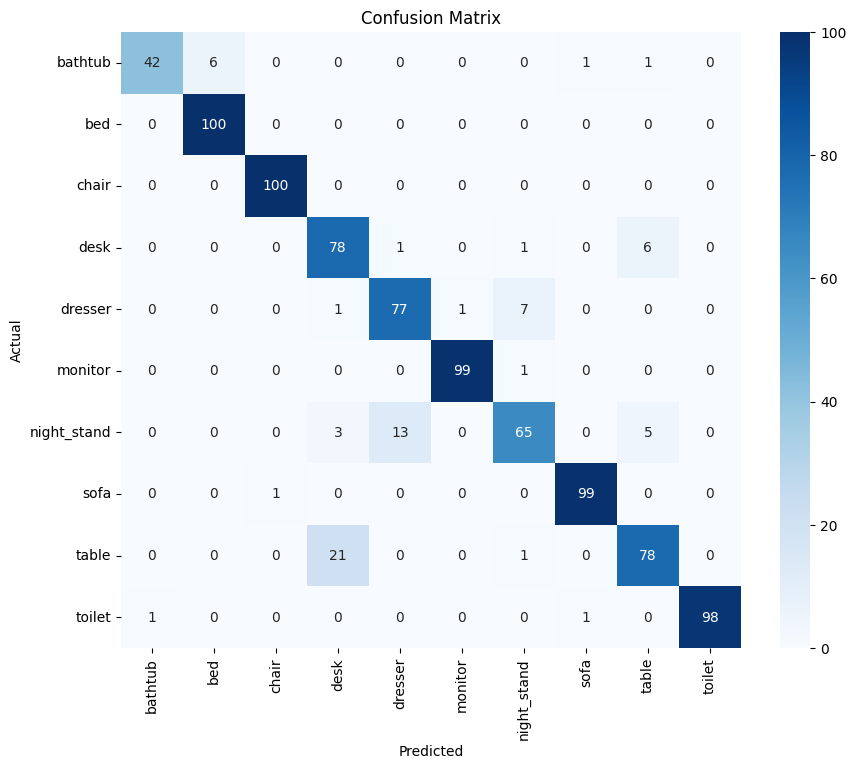

Accuracy: 0.920704845814978; F1 Score: 0.9202684591298638;

Evaluating Model at Epoch 200...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_200.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

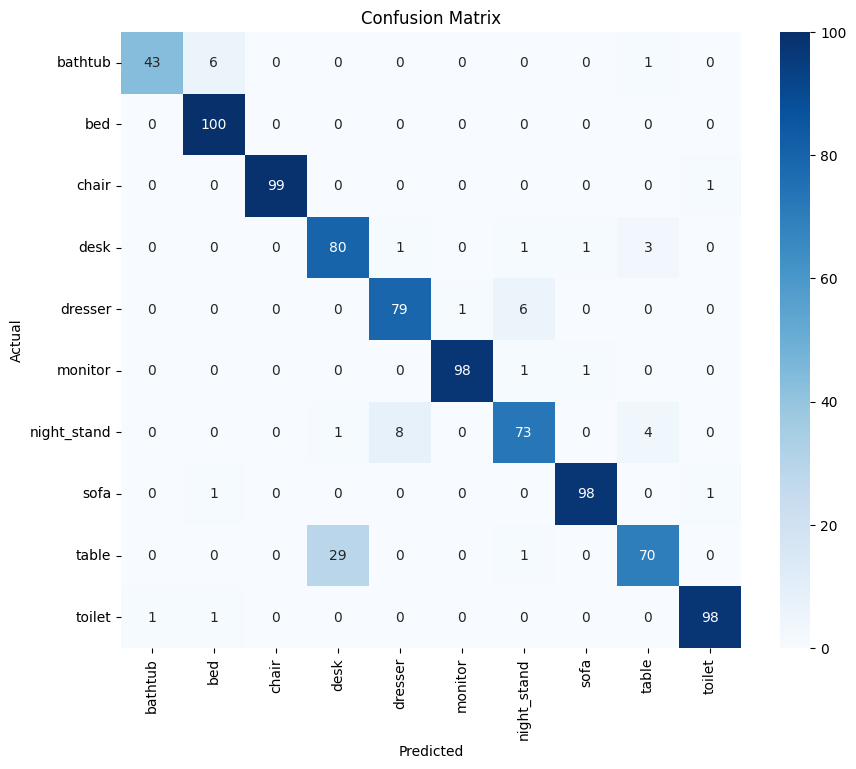

Accuracy: 0.9229074889867841; F1 Score: 0.9224386487231817;

Evaluating Model at Epoch 150...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_150.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

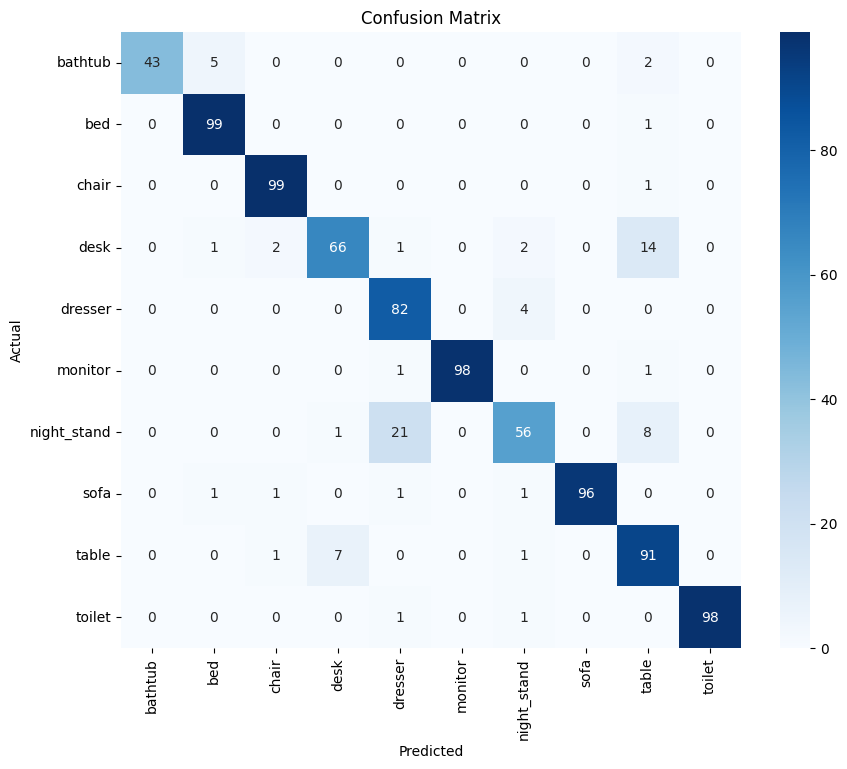

Accuracy: 0.9118942731277533; F1 Score: 0.9109372573455856;

Evaluating Model at Epoch 100...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_100.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

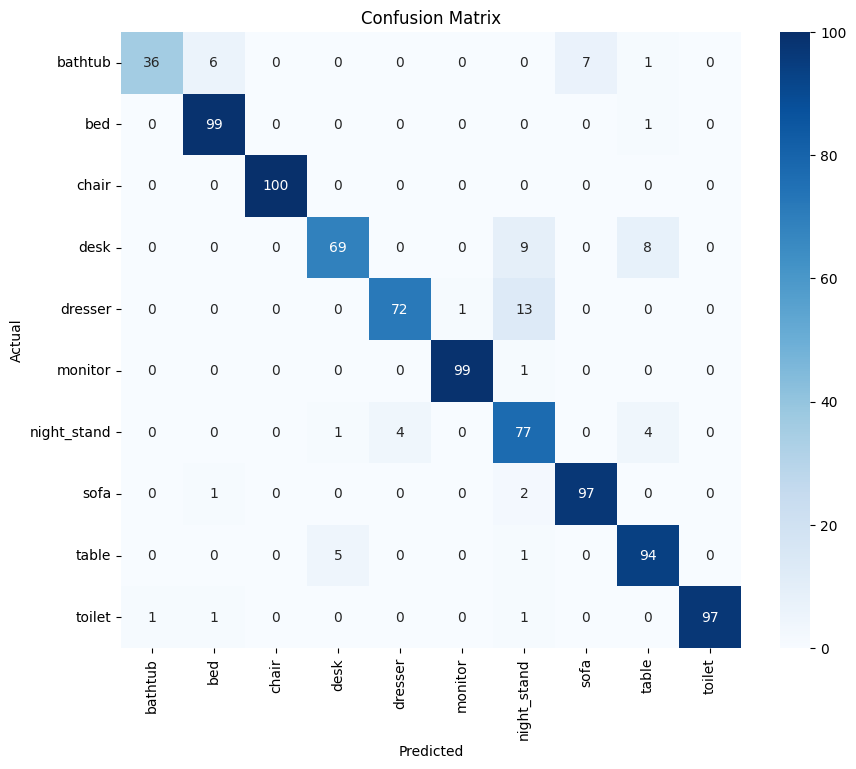

Accuracy: 0.9251101321585903; F1 Score: 0.9249507594000039;

Evaluating Model at Epoch 50...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_50.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

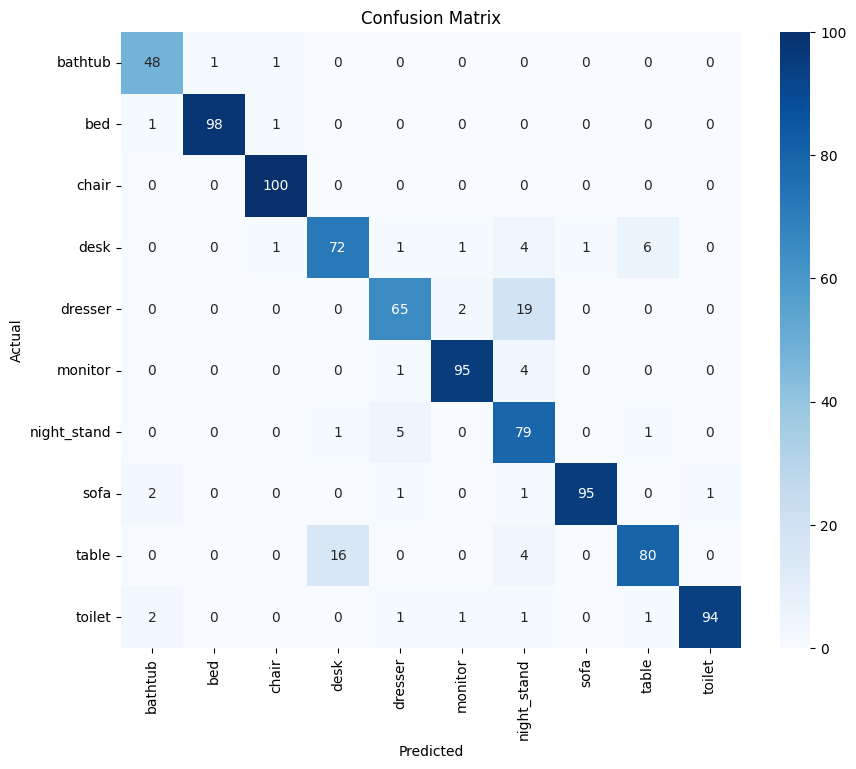

Accuracy: 0.9096916299559471; F1 Score: 0.9105906941549003;

Evaluating Model at Epoch 10...
Loading checkpoint from ./checkpoints_modelnet10/PointRTD/CR_0.6/classification_epoch_10.pth
Checkpoint loaded successfully.


Evaluating Test Set with Voting:   0%|          | 0/29 [00:00<?, ?it/s]

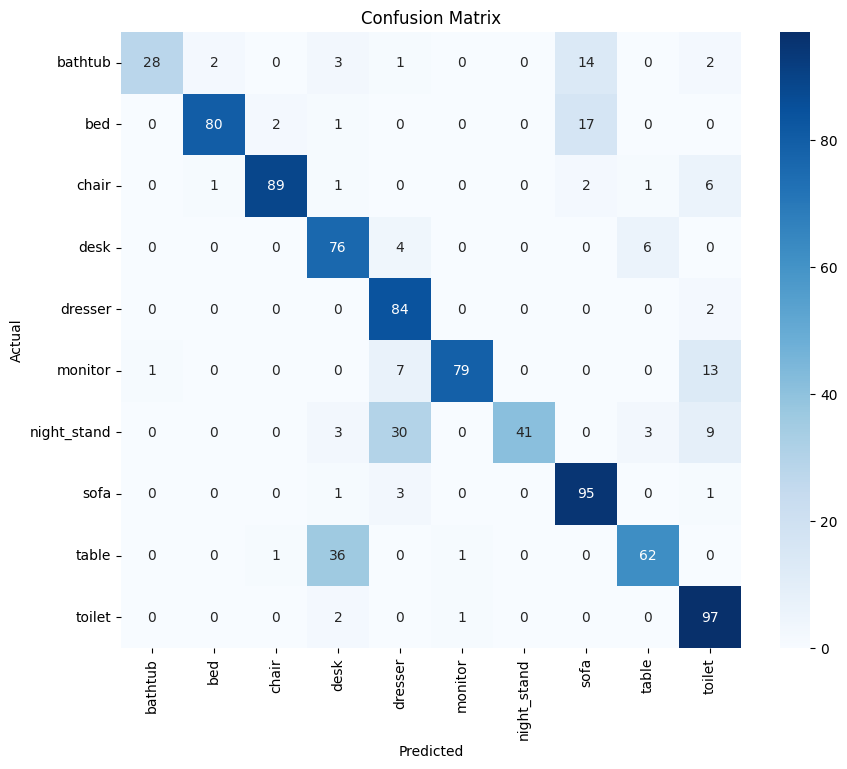

Accuracy: 0.8050660792951542; F1 Score: 0.8016774000587251;

Evaluation Results:
Epoch	Accuracy	F1 Score
300	0.9218		0.9214
250	0.9207		0.9203
200	0.9229		0.9224
150	0.9119		0.9109
100	0.9251		0.9250
50	0.9097		0.9106
10	0.8051		0.8017


In [9]:
# --- Main Evaluation Loop ---
checkpoint_epochs = [10, 50, 100, 150, 200, 250, 300]
checkpoint_epochs.reverse()
results = []

class_names = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

for epoch in checkpoint_epochs:
    checkpoint_path = f"./checkpoints_modelnet10/PointRTD/CR_{CORRUPTION_RATIO}/classification_epoch_{epoch}.pth"
    # checkpoint_path = f"./checkpoints_modelnet10/PointRTD/CR_{CORRUPTION_RATIO}/best_model_epoch_106.pth"
    print(f"\nEvaluating Model at Epoch {epoch}...")
    
    try:
        load_classification_checkpoint(classification_model, checkpoint_path)
        test_accuracy_voting, test_f1_score_voting, conf_matrix = evaluate_model_with_voting(
            classification_model, test_loader, num_votes=10, class_names=class_names
        )
        print(f"Accuracy: {test_accuracy_voting}; F1 Score: {test_f1_score_voting};")
        results.append((epoch, test_accuracy_voting, test_f1_score_voting))
    except FileNotFoundError as e:
        print(e)

# --- Print Results ---
print("\nEvaluation Results:")
print("Epoch\tAccuracy\tF1 Score")
for epoch, acc, f1 in results:
    print(f"{epoch}\t{acc:.4f}\t\t{f1:.4f}")